In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys
sys.path.append('../scripts')  # Appending the path to access the scripts folder
from Model_Training import * 

In [32]:
# Step 1: Load the data
# Assuming 'merged_data' is the merged DataFrame containing Brent oil prices and economic indicators
# Load data (update path as needed)
data_path = 'C:/Users/Administrator/Documents/kifiya/Week_10/data/Merged_brent_oil_prices_with_Indicators.csv'
merged_data = pd.read_csv(data_path, parse_dates=['Date'])
merged_data.set_index('Date', inplace=True)

# Step 2: Drop non-numeric columns
merged_data = merged_data.select_dtypes(include=[np.number])

# Step 3: Handle missing values
merged_data.fillna(method='ffill', inplace=True)  # Forward-fill any missing values
merged_data.dropna(inplace=True)  # Drop rows with any remaining NaN values

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2928\3903032823.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)  # Forward-fill any missing values


In [33]:
# Step 4: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_data.values)

# Step 5: Create sequences for the LSTM
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, :])  # All features as input sequence
        y.append(data[i + look_back, 0])    # Brent oil price as target
    return np.array(X), np.array(y)

look_back = 60  # Sequence length
X, y = create_sequences(data_scaled, look_back)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 6: Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [34]:
# Model parameters
input_size = X.shape[2]  # Number of features
hidden_size = 50
num_layers = 2
output_size = 1

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [35]:
# Step 8: Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

c:\Users\Administrator\miniconda3\envs\jojo\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([330])) that is different to the input size (torch.Size([330, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 0.1293
Epoch [2/50], Loss: 0.0675
Epoch [3/50], Loss: 0.0555
Epoch [4/50], Loss: 0.0594
Epoch [5/50], Loss: 0.0594
Epoch [6/50], Loss: 0.0571
Epoch [7/50], Loss: 0.0551
Epoch [8/50], Loss: 0.0541
Epoch [9/50], Loss: 0.0540
Epoch [10/50], Loss: 0.0546
Epoch [11/50], Loss: 0.0552
Epoch [12/50], Loss: 0.0551
Epoch [13/50], Loss: 0.0545
Epoch [14/50], Loss: 0.0539
Epoch [15/50], Loss: 0.0536
Epoch [16/50], Loss: 0.0537
Epoch [17/50], Loss: 0.0538
Epoch [18/50], Loss: 0.0538
Epoch [19/50], Loss: 0.0539
Epoch [20/50], Loss: 0.0539
Epoch [21/50], Loss: 0.0539
Epoch [22/50], Loss: 0.0539
Epoch [23/50], Loss: 0.0537
Epoch [24/50], Loss: 0.0536
Epoch [25/50], Loss: 0.0535
Epoch [26/50], Loss: 0.0535
Epoch [27/50], Loss: 0.0536
Epoch [28/50], Loss: 0.0536
Epoch [29/50], Loss: 0.0536
Epoch [30/50], Loss: 0.0536
Epoch [31/50], Loss: 0.0536
Epoch [32/50], Loss: 0.0536
Epoch [33/50], Loss: 0.0536
Epoch [34/50], Loss: 0.0536
Epoch [35/50], Loss: 0.0536
Epoch [36/50], Loss: 0.0535
E

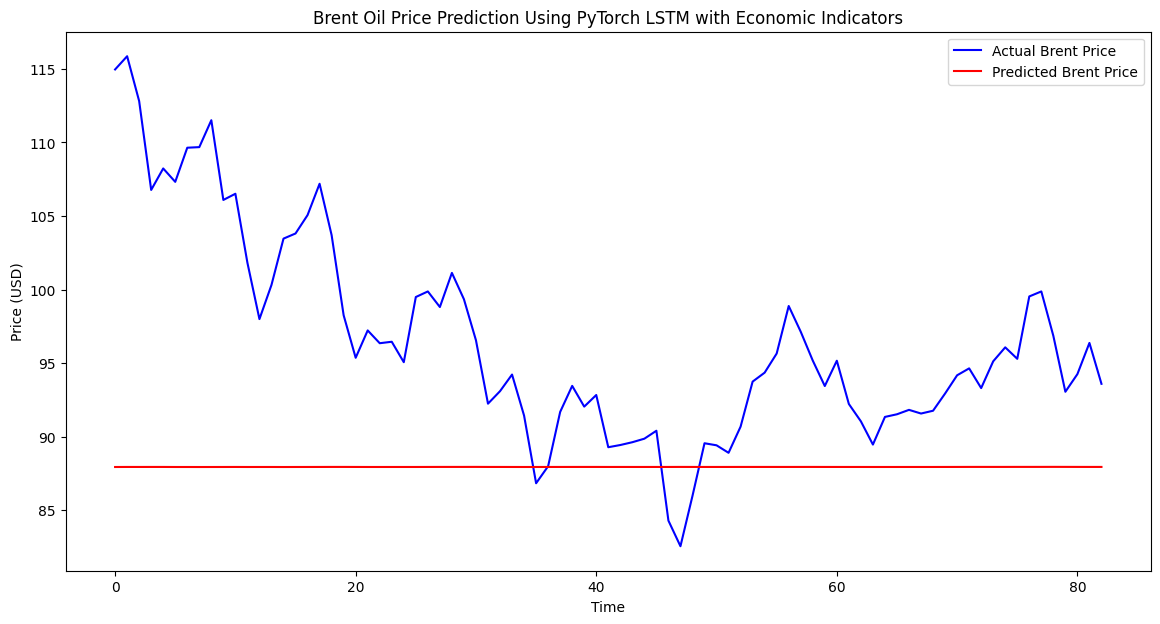

In [36]:
# Step 9: Make predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

# Step 10: Inverse transform the predictions and actual values
train_pred = train_pred.numpy()
test_pred = test_pred.numpy()
y_train = y_train.numpy()
y_test = y_test.numpy()

# Inverse transform using scaler
train_pred = scaler.inverse_transform(np.concatenate([train_pred, np.zeros((train_pred.shape[0], data_scaled.shape[1] - 1))], axis=1))[:, 0]
test_pred = scaler.inverse_transform(np.concatenate([test_pred, np.zeros((test_pred.shape[0], data_scaled.shape[1] - 1))], axis=1))[:, 0]
y_train_actual = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data_scaled.shape[1] - 1))], axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data_scaled.shape[1] - 1))], axis=1))[:, 0]

# Step 11: Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Brent Price', color='blue')
plt.plot(test_pred, label='Predicted Brent Price', color='red')
plt.title('Brent Oil Price Prediction Using PyTorch LSTM with Economic Indicators')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [37]:
# Calculate RMSE, MAE, and R-squared
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R^2": r2}

# Evaluate on test set
metrics = evaluate_model(y_test_actual, test_pred)
print("Model Evaluation Metrics:")
print(f"Root Mean Squared Error: {metrics['RMSE']:.2f}")
print(f"Mean Absolute Error: {metrics['MAE']:.2f}")
print(f"R^2 Score: {metrics['R^2']:.2f}")

Model Evaluation Metrics:
Root Mean Squared Error: 11.07
Mean Absolute Error: 8.88
R^2 Score: -1.51


In [39]:
# Define the path to save the model
model_save_path = "C:/Users/Administrator/Documents/kifiya/Week_10/Models/lstm_brent_oil_price_model.pkl"

# Save the model
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to C:/Users/Administrator/Documents/kifiya/Week_10/Models/lstm_brent_oil_price_model.pkl
